# Two Disks in a Rectangular Box: mean first event times.

Here are the simulations and calculations, numerical vs. analytical, of the mean first times and their distributions, for a series of interesting events, namely, hopping, crashing and wall-hitting.

The external file contains all the routines for initial conditions and dynamic rules.



In [4]:
include("discs_in_box.jl")

dynamics

In [29]:
#auxiliary libs for ploting
using Plots, Interact
gr()

Plots.GRBackend()

In [6]:
# A small test. w is widht, h height, r is radius for both discs.

w, h = 1.5, 1
r = 0.24

#= dynamics returns a tuple of results, in which we have the timestamp of an event, the position of the center
oof the discs, the velocites of each disc and the collition type according to following code:
+1/-1 -> disc one hits right/left wall
+2/-2 -> disc one hits top/bottom wall
+3/-3  -> disc two hits right/left wall
+4/-4 -> disc two hits top/bottom wall.
5 -> discs collide.
=#
@time times, positions, velocities, collision_types = dynamics(w, h, r, 1000000);

  3.012327 seconds (13.89 M allocations: 1016.146 MiB, 71.78% gc time)


In [7]:
showall(norm.(velocities)[1:100]) #Sanity Check

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [8]:
showall(collision_types[1:100])#Sanity Check

[-4, 2, 5, -2, -1, 2, -2, 2, 5, 3, 5, -4, -1, 4, 5, -2, -1, 3, 2, -4, 5, -4, 2, 5, 2, -1, 3, 5, 3, 5, -4, -1, 5, -2, 4, 5, 4, -2, 5, -1, 3, 2, 5, -4, -1, 3, 5, 4, 3, -4, -2, 4, -4, 5, -1, 5, 2, -2, 4, 3, 2, 5, -1, -4, 5, -1, -2, 3, 4, 5, -1, 5, 3, 5, -1, 3, -4, 5, 2, -4, 5, 3, -4, 5, -4, 2, -1, 5, -1, -2, 3, 2, 5, 3, -1, 4, -2, 5, 4, 3]

The function `dynamics` returns data on the collisions that have occurred.

In [9]:
function draw_disc!(x, y, r)
    θs = [0:0.1:2π; 0]
    xs = [x + r*cos(θ) for θ in θs]
    ys = [y + r*sin(θ) for θ in θs]
    
    plot!(xs, ys)
end

draw_disc! (generic function with 1 method)

In [10]:
@manipulate for i in slider(1:length(positions), value=1)
    x1, y1, x2, y2 = positions[i]
    
    a = w/2
    b = h/2
    
    plot([-a, a, a, -a, -a], [-b, -b, b, b, -b], aspectratio=1, leg=false, xlim=(-0.75,0.75), ylim=(-0.5,0.5))
    draw_disc!(x1, y1, r) 
    draw_disc!(x2, y2, r) 
end

Interact.Slider{Int64}(1: "input" = 1 Int64 , "", 1, 1:1000000, "horizontal", true, "d", true)

# Hopping

The data from the simulation directly gives disc and wall collision times.
The other times that we require are hopping times, both horizontal, when $x_1 = x_2$, and vertical, when $y_1 = y_2$. 

Vertical hops can be detected from the data when $y_2 - y_1$ changes sign between two consecutive collisions.
Using the relative velocity $v_2 - v_1$, the vertical hopping time when $y_2 - y_1 = 0$ can be recovered.

In [11]:
"""
Calculate the times at which horizontal hops occur
"""
function horizontal_hopping_times(times, positions, velocities)
    Δxs = [x[3] - x[1] for x in positions]  # x_2 - x_1
    Δus = [v[3] - v[1] for v in velocities]  # u_2 - u_1;
    
    # indices where there is a hop between collisions i and i+1: 
    horiz_hop_indices = find( sign(Δxs[i]) != sign(Δxs[i+1]) for i in 1:length(positions)-1 );  
    
    # x + t*u = 0   so   t = -x/u
    horiz_hopping_times = times[horiz_hop_indices] - (Δxs[horiz_hop_indices] ./ Δus[horiz_hop_indices])
    
    return horiz_hopping_times
end
## Verified by karel, it is correct.
 

"""
Calculate the times at which horizontal hops occur
"""
function vertical_hopping_times(times, positions, velocities)
    Δys = [x[4] - x[2] for x in positions]  # y_2 - y_1
    Δvs = [v[4] - v[2] for v in velocities]  # v_2 - v_1;
    
    # indices where there is a hop between collisions i and i+1: 
    vert_hop_indices = find( sign(Δys[i]) != sign(Δys[i+1]) for i in 1:length(positions)-1 );  
    
    # x + t*u = 0   so   t = -x/u
    vert_hopping_times = times[vert_hop_indices] - (Δys[vert_hop_indices] ./ Δvs[vert_hop_indices])
    
    return vert_hopping_times
end

vertical_hopping_times

 ## Analytical Expressions
 
 ### 1. Volume
 
 The Volume function has three regimenes. First, when all hopping is possible, that is, (convention $w>h$) $r<h/4$. Then, horizontal hopping is excluded, but vertical still posible, i.e. $h/4\leq r < w/4$. At last, no hopping is possible, that means, $w/4\leq r \leq r_{max}$. 
 
 The Excluded Volume is evaluated in two parts: the round part and the triangular part. We use the notation "Neg" in the functions to indicate that is the excluded volume, "free" to indicate all hoping is posible, "vhopp" to indicate only vertical hopping is possible, and "nohopp" to indicate no hopping is possible.

In [12]:
cte=3π/2 #E=1/2, -> abs(v^2)=1 as above
rhmax= h/4 #maximal radius in which a horizontal hopp is possible
rvmax= w/4 #maximal radius in which a vertical hopp is possible (any hopp is not posible in our geometry after this)
rmax=  (h+w-√(2*h*w))/2   #maximal possible radius for discs


volBox(a,b)=16*a^2*b^2
volNegfree(a,b,r)=16*π*a*b*r^2-64/3*r^3*(a+b)+8*r^4

expresioncircularvol(a,b,r,θ)=32*r^2*a*b*θ +64/3*r^3*(a*cos(θ)-b*sin(θ)) + 8*r^4*sin(θ)^2

function volNegCircle(a,b,r)
    # This function only has use if r>rhmax
    α=asin(b/r)
    if(r<rvmax)
        β=0
    else
        β=acos(a/r)
    end
    result=expresioncircularvol(a,b,r,α)-expresioncircularvol(a,b,r,β)
    return result
end

vollowertriangle(a,b,r)= 32*a^2*b*sqrt(r^2-a^2)-32/3*a^2*(r^2-a^2+2*b*sqrt(r^2-a^2))+8*a^2*(r^2-a^2)

voluppertriangle(a,b,r)= 32*b^2*a*sqrt(r^2-b^2)-32/3*b^2*(r^2-b^2+2*a*sqrt(r^2-b^2))+8*b^2*(r^2-b^2)


function volNegGeneral(a,b,r)
    if (r<rhmax)
        result=volNegfree(a,b,r)
    elseif (rhmax<=r) && (r<rvmax)
       # println("a=",a," r =" , r, "r^2-a^2 = ", r^2-a^2)
        result=volNegCircle(a,b,r)+voluppertriangle(a,b,r)
    else
        result=volNegCircle(a,b,r)+voluppertriangle(a,b,r)+vollowertriangle(a,b,r)
    end
    return result
end

function vol(a,b,r) 
    result=volBox(a,b)-volNegGeneral(a,b,r)
  #  print(" vol = ", result, " \t ")
    return result
end 

vol (generic function with 1 method)

## 2 Areas

#### Hopping Areas

In [13]:
area_vert_hopp(a,b,r)=16*√(2)*b*(r-a)^2 #This is right, but SymPy has problems refining Heaviside function and DiracDelta
area_horiz_hopp(a,b,r)=16*√(2)*a*(r-b)^2 # The Area HAS TWO SIDES. This is weird, but true.
#Those two don't generalize for larger r--- they just stop making sense.

area_horiz_hopp (generic function with 1 method)

### collision with wall
When hopping is no longer possible, the volume is split into disjoint components. This is equivalent to a factor
in the area of 2 or 4. Given that this only is relevant in this case, we take put those factors here. In the case of collition between discs, that factor is canceled as both the Volume and Area get split equally.

In [14]:
area_wall_free(a,b,r)=8*a*b^2-4*π*b*r^2+16/3*r^3 #perfect but needs generalization

exprpos_wall(a,b,r)=8*a*b^2
exprcircular_wall(a,b,r,θ)=8*b*r^2*θ+16/3*r^3*(cos(θ)) #sector

# la parte del "upper triangle"
a_wall_uppt(a,b,r)=8/3*b^2*sqrt(r^2-b^2)
a_wall_lowt(a,b,r)=8/3*a^2*sqrt(r^2-a^2)

function area_wall(a,b,r)
    if (r<rhmax)
        result=area_wall_free(a,b,r)
    elseif (rhmax<=r) && (r<rvmax)
         α=asin(b/r)
         negativo=exprcircular_wall(a,b,r,α)-exprcircular_wall(a,b,r,0)+a_wall_uppt(a,b,r)
         result=(exprpos_wall(a,b,r)-negativo)*2 # Actually is the Volume that gets split into disjoint componets
    else
        α=asin(b/r)
        β=acos(a/r)
        negativo=0 # (exprcircular_wall(a,b,r,α)-exprcircular_wall(a,b,r,β))+a_wall_uppt(a,b,r)+a_wall_lowt(a,b,r)
        result=(exprpos_wall(a,b,r)-negativo)*4
    end
    return result
end

area_wall (generic function with 1 method)

###  Collition between discs:
Although here the space get also split,the factor accounting for that does not appear as it cancels itself in Area and Volume.

In [15]:
area_col_free(a,b,r)=(16*π*a*b*r-32*(a+b)*r^2+16*r^3)*√(2) 
exprcircular_col(a,b,r,θ)=16*√2*(2*a*b*r*θ + 2*r^2*(a*cos(θ)-b*sin(θ)) + r^3*sin(θ)^2 )

function area_col(a,b,r)
    if (r<rhmax)
        result=area_col_free(a,b,r)
    elseif (rhmax<=r) && (r<rvmax)
     #   println(b, " ", r, " ", b/r)
        α=asin(b/r)
        result=exprcircular_col(a,b,r,α)-exprcircular_col(a,b,r,0)
    else
        α=asin(b/r)
        β=acos(a/r)        
        result=exprcircular_col(a,b,r,α)-exprcircular_col(a,b,r,β)   
    end
  #  print(" acol= ",result,  " \n ")
    return result
end

area_col (generic function with 1 method)

In [16]:
rango=(0.1, 0.2, 0.2501)
imagen=map(x->area_col(w/2-x,h/2-x,x),rango)

(1.3956909623144902, 0.9881971714694461, 0.4525529933634218)

### 3. Mean Times Machta Zwanzig

We combine area and volume with the general factor to obtain the theoretical mean times according to Machta Zwanzig Formula

In [17]:
horiz_hop_analytical(a,b,r)=cte*vol(a,b,r)/area_horiz_hopp(a,b,r)
vert_hop_analytical(a,b,r)=cte*vol(a,b,r)/area_vert_hopp(a,b,r)
right_wall_analytical(a,b,r)=cte*vol(a,b,r)/area_wall(a,b,r) #perfect
disc_collision_analytical(a,b,r)=cte*vol(a,b,r)/area_col(a,b,r)

horiz_hop_analytical_d(a, b, r) = (3π / (2*√(2))) * (2*a^2*b^2 - 2π*a*b*r^2 + ((a+b)/3)*(2*r)^3 - r^4) / (a*√(2)*(b-r)^2)
disc_collision_analytical_d(a, b, r) = (3π / (2*√(2))) * (2*a^2*b^2 - 2π*a*b*r^2 + ((a+b)/3)*(2*r)^3 - r^4) / (2π*a*b*r - 4*(a+b)*r^2 + 2r^3 )

disc_collision_analytical_d (generic function with 1 method)

The simulation function gives us a quick sanity check on the four event formulas above, but it doesn't give statistics. We relegate that to some other functions below.

In [18]:
function simulation(w, h, num_collisions=10^5)
    
    num_horiz_hop_data=Float64[]
    exact_horiz_hop_data=Float64[]
    
    num_vert_hop_data=Float64[]
    exact_vert_hop_data=Float64[]
    
    num_disc_collision_data = Float64[]
    exact_disc_collision_data = Float64[]
    
    num_rightwall_data = Float64[]
    exact_rightwall_data = Float64[]
    
    
    
    exhopd = Float64[]
    excold = Float64[]
    
    
    rs = 0.005:0.005:rmax #we do it until it cannot be done anymore
    
    for r in rs
        print(r, " ")
        
        a = w/2 - r
        b = h/2 - r
    
        times, positions, velocities, collision_types = dynamics(w, h, r, num_collisions);
        
        
        horiz_hopping_times = horizontal_hopping_times(times, positions, velocities)

        vert_hopping_times = vertical_hopping_times(times, positions, velocities)

        if(r<rhmax)
            push!(num_vert_hop_data, mean(diff(vert_hopping_times)))   # diff gives inter-hop times
            push!(exact_vert_hop_data, vert_hop_analytical(a, b, r))
        end
        
        push!(num_horiz_hop_data, mean(diff(horiz_hopping_times)))   # diff gives inter-hop times
        push!(exact_horiz_hop_data, horiz_hop_analytical(a, b, r))
        push!(exhopd, horiz_hop_analytical_d(a, b, r))
        
        
        disc_collision_times = times[collision_types .== 5]
        push!(num_disc_collision_data, mean(diff(disc_collision_times)))   # diff gives inter-hop times
        push!(exact_disc_collision_data, disc_collision_analytical(a, b, r))
        push!(excold, disc_collision_analytical_d(a, b, r))
    
        rightwall_times = times[collision_types .== 1]
        push!(num_rightwall_data, mean(diff(rightwall_times)))   # diff gives inter-hop times
        push!(exact_rightwall_data, right_wall_analytical(a, b, r))
        
    end
    
    return (rs,  num_vert_hop_data, exact_vert_hop_data, num_horiz_hop_data, exact_horiz_hop_data, num_disc_collision_data, 
        exact_disc_collision_data, num_rightwall_data, exact_rightwall_data, excold, exhopd)
                
    end

simulation (generic function with 2 methods)

# A general Test

This first simulation produces a general sanity test. More accurate simulations for the specific events are below . The Figures here are NOT the ones in the paper, this are averages done with lower samples meant as a sanity check.

In [19]:
w, h = 1.5, 1.0
nevents=10^5
(rs, num_vert_hop_data, exact_vert_hop_data,  num_horiz_hop_data, exact_horiz_hop_data, num_disc_collision_data, 
    exact_disc_collision_data, num_rightwall_data, exact_rightwalldata, excold, exhopd)= simulation(w, h, nevents);

0.005 0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.17500000000000002 0.18 0.185 0.19 0.195 0.2 0.20500000000000002 0.21 0.215 0.22 0.225 0.23 0.23500000000000001 0.24 0.245 0.25 0.255 0.26 0.265 0.27 0.275 0.28 0.28500000000000003 0.29 0.295 0.3 0.305 0.31 0.315 0.32 0.325 0.33 0.335 0.34 0.34500000000000003 0.35000000000000003 0.355 0.36 0.365 0.37 0.375 0.38 

In [20]:
using JLD # To save the data, and save us headeaches

INFO: Recompiling stale cache file /home/karel/.julia/lib/v0.6/Blosc.ji for module Blosc.
INFO: Recompiling stale cache file /home/karel/.julia/lib/v0.6/JLD.ji for module JLD.


In [21]:
save("DatosNumericos10a5.jld", "rs", rs, 
    "num_vert_hop_data", num_vert_hop_data,
    "num_horiz_hop_data", num_horiz_hop_data,
    "num_disc_collision_data", num_disc_collision_data,
    "num_rightwall_data", num_rightwall_data
)

In [22]:
Plots.scatter(rs, num_rightwall_data, m=:square, label="numerical", size=(650,420), guidefont=(30,"Courier"))
dibujo=plot!(rs, exact_rightwalldata, label="exact", linewidth=2) #absolut PERFECT
#savefig("test.png")
dibujo


In [ ]:
3*pi*1.5/2 #Limit for r->0 above!

In [23]:
Plots.scatter(rs, num_disc_collision_data, m=:square, label="numerical")
plot!(rs, exact_disc_collision_data, label="exact")
plot!(rs, excold, label="DavEx") #DFormula that doesn't account for the discontinuites
plot!(rs, zeros(rs), lw=2, label="vertical zero line")

In [24]:
rhmax, rvmax, rmax

(0.25, 0.375, 0.3839745962155614)

In [25]:
#rsredux=rs[find( r<rhmax ) in rs]
rsredux=filter(r->r<rhmax, rs)
plot(rsredux, num_vert_hop_data, m=:square, label="numerical")
plot!(rsredux, exact_vert_hop_data, label="exact") 
#plot!(rs, exhopd, label="DavidEx")
#Formula David, raiz de dos muy grande 

## Statistics.

Some Plots of interesting statistical propiertes, such as histograms.

In [26]:
using StatsBase

In [27]:
radiosinteresantes=(0.01, 0.075, 0.125, 0.15, 0.2, 0.24, 0.249)
thopforhisto=Dict{Float64, Array}()

binlim=10
paso=0.5
rangobins=0:paso:binlim
rangoplot=rangobins[1:end-1]+paso/2

hth=Dict{Float64, Any}()

for r in radiosinteresantes
    w,h=1.5,1
    num_collisions=500000
    times, positions, velocities, collision_types = dynamics(w, h, r, num_collisions);
    thopforhisto[r] = horizontal_hopping_times(times, positions, velocities);
    #normalized histograms
    aux=fit(Histogram, diff(thopforhisto[r]), rangobins, closed=:left)
    hth[r]=aux.weights/sum(aux.weights)
end

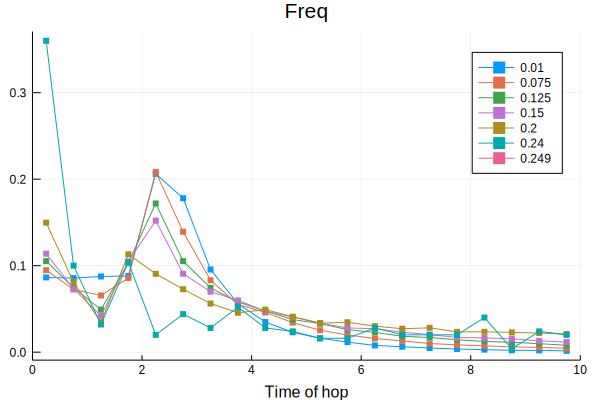

In [30]:
p=plot(xlim=(0,binlim), xlabel="Time of hop", title="Freq")
for r in radiosinteresantes
    plot!(rangoplot,hth[r], marker=(:rect, 3, :match, stroke(0,0, :match, :line)), lc=:match, label="$r")
end
savefig("histogramahorizontalhopsemidecente01.png")
p

# Hitting right wall

Simulation to obtain statistics of collision of disk 1 with the right wall.

In [31]:
function simulationhitwall(w, h, num_collisions=10^5)
    
    num_hitting_times = Float64[]
    exact_hitting_times = Float64[]
    σ=Float64[]
    stderror=Float64[]
    
    rs = 0.0051:0.00256:rmax
    
    for r in rs
        print(r, " ")
        
        a = w/2 - r
        b = h/2 - r
    
        nhits=0
        disc_1_hits_right_wall_times=[]
        while(nhits<200)
            times, positions, velocities, collision_types = dynamics(w, h, r, num_collisions); 
            disc_1_hits_right_wall_times = diff(times[collision_types .== 1])
            nhits=length(disc_1_hits_right_wall_times)
   #         println(r, " ", nhits, "tu abuela", disc_1_hits_right_wall_times[1])
        end
        
        auxhit=mean(disc_1_hits_right_wall_times)
   #     println(auxhit)
        push!(num_hitting_times, auxhit)
        
        push!(exact_hitting_times, right_wall_analytical(a, b, r))
        aux=std(disc_1_hits_right_wall_times)
        push!(σ, aux)
        push!(stderror, aux/sqrt(nhits))
        
        
    end
    
    return rs, num_hitting_times, exact_hitting_times, σ, stderror
end

simulationhitwall (generic function with 2 methods)

In [35]:
nevents=10^6
rs, num_hitting_times, exact_hitting_times, stdeviation, stderror =simulationhitwall(1.5, 1.0, nevents);

0.0051 0.00766 0.01022 0.012780000000000001 0.015340000000000001 0.017900000000000003 0.020460000000000002 0.023020000000000002 0.025580000000000002 0.028140000000000002 0.0307 0.033260000000000005 0.035820000000000005 0.038380000000000004 0.040940000000000004 0.043500000000000004 0.046060000000000004 0.048620000000000003 0.05118 0.05374 0.0563 0.05886 0.06142 0.06398000000000001 0.06654 0.06910000000000001 0.07166 0.07422000000000001 0.07678 0.07934000000000001 0.0819 0.08446000000000001 0.08702000000000001 0.08958 0.09214000000000001 0.0947 0.09726000000000001 0.09982 0.10238000000000001 0.10494 0.10750000000000001 0.11006 0.11262000000000001 0.11518 0.11774000000000001 0.1203 0.12286000000000001 0.12542 0.12798 0.13054000000000002 0.13310000000000002 0.13566 0.13822 0.14078000000000002 0.14334000000000002 0.1459 0.14846 0.15102000000000002 0.15358000000000002 0.15614 0.1587 0.16126000000000001 0.16382000000000002 0.16638 0.16894 0.1715 0.17406000000000002 0.17662000000000003 0.17918

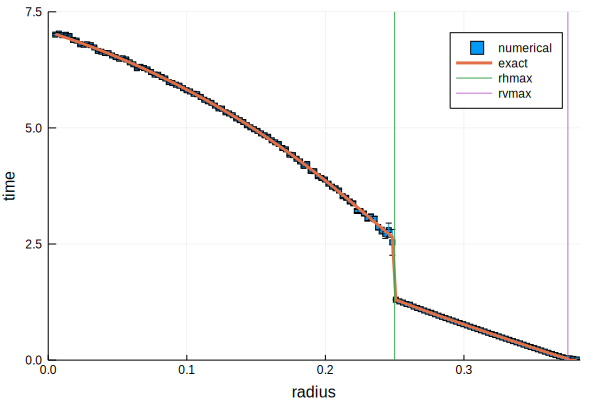

In [40]:
linea1x=[rhmax, rhmax]
linea1y=[0,7.5]
linea2x=[rvmax,rvmax]
linea2y=linea1y
p=plot(xlim=(0,rmax), ylim=(0,7.5),xlabel="radius",ylabel="time" )
scatter!(rs, num_hitting_times, m=:square, ms=2, label="numerical", yerror=stderror)
plot!(rs, exact_hitting_times, label="exact", lw=3)
plot!(linea1x,linea1y,label="rhmax", lw=1.0)
plot!(linea2x, linea2y,label="rvmax", lw=1.0)
savefig("../articulo/figures/HitRightWall01.png")
p

In [34]:
nevents

100000

# Disc collisions

In [41]:
function simulation_disc_collisions(w, h, num_collisions=10^5)
    
    num_times = Float64[]
    exact_times = Float64[]
    σ=Float64[]
    stderror=Float64[]
    
    rs = 0.0051:0.005:rmax
    
    for r in rs
        print(r, " ")
        
        a = w/2 - r
        b = h/2 - r
    
        times, positions, velocities, collision_types = dynamics(w, h, r, num_collisions);
        
        collision_times = diff(times[collision_types .== 5])
        nhits=length(collision_times)
        
        push!(num_times, mean(collision_times))   # diff gives inter-hop times
        push!(exact_times, disc_collision_analytical(a, b, r))
        aux=std(num_times)
        push!(σ, aux)
        push!(stderror, aux/sqrt(nhits))
        
        
    end
    
    return rs, num_times, exact_times, σ, stderror
end

simulation_disc_collisions (generic function with 2 methods)

In [59]:
rs, num_disc_collision_times, exact_disc_collision_times, colsig, colerror = simulation_disc_collisions(w, h, nevents);

0.0051 0.010100000000000001 0.0151 0.0201 0.0251 0.030100000000000002 0.0351 0.040100000000000004 0.0451 0.0501 0.0551 0.0601 0.0651 0.0701 0.0751 0.0801 0.08510000000000001 0.0901 0.0951 0.10010000000000001 0.1051 0.1101 0.11510000000000001 0.1201 0.1251 0.1301 0.1351 0.1401 0.1451 0.1501 0.15510000000000002 0.1601 0.1651 0.1701 0.1751 0.1801 0.18510000000000001 0.1901 0.1951 0.2001 0.2051 0.2101 0.2151 0.22010000000000002 0.2251 0.2301 0.2351 0.2401 0.2451 0.2501 0.2551 0.2601 0.2651 0.2701 0.2751 0.2801 0.2851 0.2901 0.29510000000000003 0.30010000000000003 0.3051 0.3101 0.3151 0.3201 0.3251 0.3301 0.3351 0.3401 0.3451 0.3501 0.3551 0.36010000000000003 0.3651 0.3701 0.3751 0.3801 

In [58]:
linea1y=[0,80]
linea2y=linea1y
p=plot(xlim=(0,rmax), ylim=(0,80),xlabel="radius",ylabel="time" )
scatter!(rs, num_disc_collision_times, m=:square, ms=2, label="numerical", yerror=colerror)
plot!(rs, exact_disc_collision_times, label="exact", lw=2)
plot!(linea1x,linea1y,label="rhmax", lw=1.0)
plot!(linea2x, linea2y,label="rvmax", lw=1.0)
savefig("../articulo/figures/DiscCollitions01.png")
p

LoadError: [91mBoundsError: attempt to access 75-element StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}} at index [1:76][39m

## Vertical hopping

In [53]:
function simulation_vert_hopping(w, h, num_collisions=10^5)
    
    num_times = Float64[]
    exact_times = Float64[]
    
     σ=Float64[]
    stderror=Float64[]
    
    
    rs = 0.005:0.005:rvmax
    
    for r in rs
        print(r, " ")
    
        a = w/2 - r
        b = h/2 - r
    
        vert_hopping_times=[]
        nhits=0
    
    #    while(nhits<200)
            times, positions, velocities, collision_types = dynamics(w, h, r, num_collisions);
            vert_hopping_times = diff(vertical_hopping_times(times, positions, velocities))
            nhits=length(vert_hopping_times)
#        end
             
        push!(num_times, mean(vert_hopping_times))   # diff gives inter-hop times
        push!(exact_times, vert_hop_analytical(a, b, r))
        
        aux=std(vert_hopping_times)
        push!(σ, aux)
        push!(stderror, aux/sqrt(nhits))
       
    end

    return rs, num_times,exact_times, σ, stderror


end

simulation_vert_hopping (generic function with 2 methods)

In [54]:
rs, num_vert_hopping_times, exact_vert_hopping_times , vhsigma, vhoperror = simulation_vert_hopping(w, h, nevents);

0.005 0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 0.255 0.26 0.265 0.27 0.275 0.28 0.285 0.29 0.295 0.3 0.305 0.31 0.315 0.32 0.325 0.33 0.335 0.34 0.345 0.35 0.355 0.36 0.365 0.37 0.375 

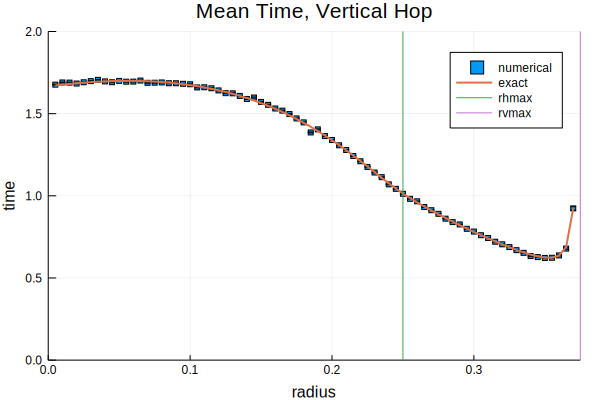

In [56]:
linea1y=[0,2]
linea2y=linea1y
p=plot(xlim=(0,rvmax), ylim=(0,2),title="Mean Time, Vertical Hop", xlabel="radius",ylabel="time" )
scatter!(rs, num_vert_hopping_times, m=:square, ms=2, label="numerical", yerror=vhoperror)
plot!(rs, exact_vert_hopping_times, label="exact", lw=2)
plot!(linea1x,linea1y,label="rhmax", lw=1.0)
plot!(linea2x, linea2y,label="rvmax", lw=1.0)
savefig("../articulo/figures/VertHop01.png")
p